### Step 1: Importing the necessary Libraries


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

print("Setup Complete. TensorFlow Version:", tf.__version__)

Setup Complete. TensorFlow Version: 2.19.0


### Step 2: Loading and Prepareing Data

In [4]:
# Define main constants
IMAGE_SIZE = 224 # The image size MobileNetV2 was trained on
BATCH_SIZE = 32
DATA_DIR = 'data' # This should point to your 'data' folder

# Create a tool to automatically load and augment training images
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Scale pixel values from 0-255 to 0-1
    rotation_range=20,         # Randomly rotate images
    horizontal_flip=True       # Randomly flip images horizontally
)

# For validation and test data, we only rescale. No augmentation.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from the directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 471 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


###  Step 3: Build the Model (Model Architecture)
##### Here, we'll construct the "brain" of our operation using a powerful pre-trained model called MobileNetV2. This technique is called Transfer Learning.

In [5]:
# Loading the base MobileNetV2 model, without its final classification layer
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model's layers so we don't change them during training
base_model.trainable = False

# Add our own custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Helps prevent the model from just memorizing data
    layers.Dense(3, activation='softmax') # 3 outputs for our 3 classes
])

# Display the architecture of our final model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Step 4: Compiling the Model and preparing for Training

In [6]:
# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Start training!
print("\nStarting model training...")
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)
print("Model training complete.")


Starting model training...


c:\Users\Rakesh Roshan Allam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5256 - loss: 1.1423 - val_accuracy: 0.8644 - val_loss: 0.4667
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - accuracy: 0.8225 - loss: 0.4437 - val_accuracy: 0.8644 - val_loss: 0.3524
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 589ms/step - accuracy: 0.9101 - loss: 0.2914 - val_accuracy: 0.8475 - val_loss: 0.3947
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.9054 - loss: 0.2542 - val_accuracy: 0.8475 - val_loss: 0.3703
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 719ms/step - accuracy: 0.9400 - loss: 0.2052 - val_accuracy: 0.8814 - val_loss: 0.3253
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9092 - loss: 0.2165 - val_accuracy: 0.8814 - val_loss: 0.3242
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9512 - loss: 0.1420 - val_accuracy: 0.8305 - val_loss: 0.3742
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9452 - loss: 0.1705 - val_accuracy: 0.8644 -

### Step 5: Testing the model performance


Found 60 images belonging to 3 classes.
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Rakesh Roshan Allam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Generating Confusion Matrix...


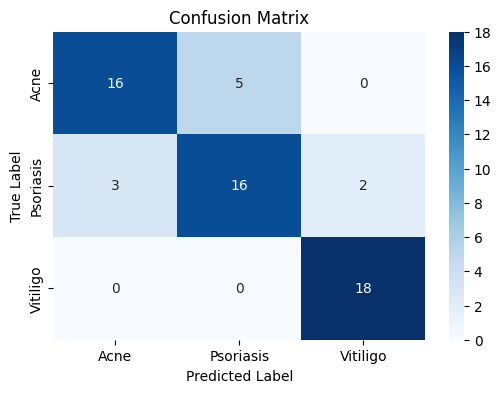


Classification Report:
              precision    recall  f1-score   support

        Acne       0.84      0.76      0.80        21
   Psoriasis       0.76      0.76      0.76        21
    Vitiligo       0.90      1.00      0.95        18

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.84        60
weighted avg       0.83      0.83      0.83        60



In [8]:
# Create a data generator for the test set.
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,      # Process one image at a time for evaluation
    shuffle=False,     # IMPORTANT: Do not shuffle the test data
    class_mode='categorical'
)

# Get the model's predictions for the test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability
y_true = test_generator.classes          # Get the true labels
class_names = list(test_generator.class_indices.keys()) # Get the class names

# 1. Confusion Matrix: A visual table of correct vs. incorrect predictions
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report: A text summary of precision, recall, and f1-score
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

### Step 6: Saving the Generated Model

In [9]:
print("\nSaving model and class names...")

# The 'saved_model' directory was created at the beginning.
# This command ensures it exists, just in case.
os.makedirs('saved_model', exist_ok=True) 

# Save the entire trained model to a single H5 file.
model.save('saved_model/skin_model.h5')

# We also need to save the mapping of class indices (0, 1, 2) to class names.
# Our web app will use this to show the correct disease name.
class_indices = train_generator.class_indices
class_names_map = {v: k for k, v in class_indices.items()}
with open('saved_model/class_names.json', 'w') as f:
    json.dump(class_names_map, f)

print("\nProcess complete! Your trained model is now in the 'saved_model' folder.")


Saving model and class names...

Process complete! Your trained model is now in the 'saved_model' folder.
